In [1]:
import seaborn as sns
import pandas as pd

df_16 = pd.read_csv("../results/16jobs_results.csv")
df_4 = pd.read_csv("../results/4jobs_results.csv")


In [2]:
df_16

,experiment,repetition,runtime,max_mem
0,lustre,0,74.89,1942844
1,lustre,0,75.42,1942156
2,mem_all,0,143.03,1961564
3,mem_final,0,184.31,1960364
4,lustre,1,54.58,1939564
5,mem_final,1,184.28,1958296
6,lustre,1,54.51,1942788
7,mem_all,1,143.67,1959804
8,lustre,2,70.98,1942112
9,mem_final,2,186.34,1958784


# Experiment 1 - 16 parallel jobs & 39 617MB images incremented 10 times (total data generated: ~234GiB)

(0.0, 193.0525)

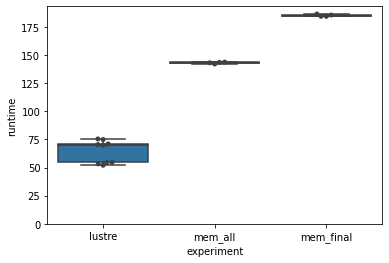

In [3]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_16)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_16, color=".25")
ax.set_ylim(bottom=0)

## Experiment 2 - 4 parallel jobs & 39 617MB images incremented 10 times (total data generated:~234GiB)

(0.0, 202.513)

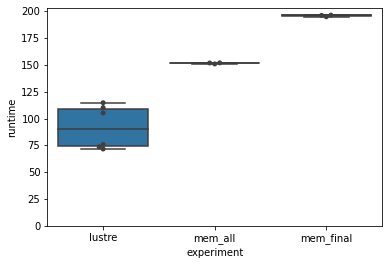

In [4]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_4)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_4, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 - 16 parallel jobs & Single node multidisk (all 6) & 39 617MB images incremented 10 times

In [5]:
multidisk = pd.read_csv("../results/multidisk_res.csv")
print(multidisk)
multidisk['flush_time_s'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[1]) if pd.notnull(x) else 0)
multidisk['flush_time'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[0])*60 if pd.notnull(x) else 0)
multidisk['flush_time_s'] = multidisk['flush_time'] + multidisk['flush_time_s']
multidisk['runtime'] = multidisk['runtime'].apply(lambda x: float(x))
multidisk = multidisk[['experiment', 'repetition', 'runtime', 'disk_files', 'total_flush', 'flush_time_s']]

  experiment  repetition  runtime  max_mem flush_time  disk_files  total_flush
0    mem_all           0    69.69        0   0m4.871s         137          390
1  mem_final           0    82.04        0   0m3.268s          24           39
2     lustre           0   103.54        0        NaN           0            0
3  mem_final           1    77.31        0   0m0.139s          23           39
4     lustre           1   107.62        0        NaN           0            0
5    mem_all           1    71.09        0  4m16.594s         133          390
6  mem_final           2    71.44        0   0m0.124s          21           39
7     lustre           2    96.98        0        NaN           0            0
8    mem_all           2    69.80        0   0m4.732s         135          390


In [6]:
multidisk

,experiment,repetition,runtime,disk_files,total_flush,flush_time_s
0,mem_all,0,69.69,137,390,4.871
1,mem_final,0,82.04,24,39,3.268
2,lustre,0,103.54,0,0,0.000
3,mem_final,1,77.31,23,39,0.139
4,lustre,1,107.62,0,0,0.000
5,mem_all,1,71.09,133,390,256.594
6,mem_final,2,71.44,21,39,0.124
7,lustre,2,96.98,0,0,0.000
8,mem_all,2,69.80,135,390,4.732


(0.0, 109.51650000000001)

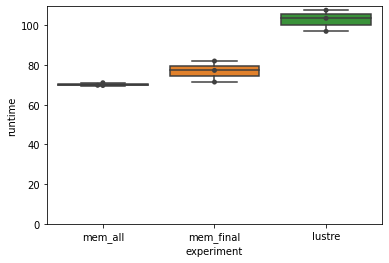

In [7]:
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

(0.0, 340.48999999999995)

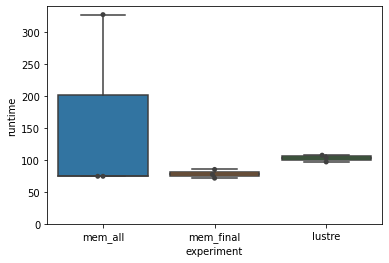

In [8]:
multidisk['runtime'] = multidisk['runtime'] + multidisk['flush_time_s']
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 Gantt Charts

In [74]:
def bokeh_gantt(df):
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool
    from bokeh.plotting import figure
    
    output_notebook()
    source = ColumnDataSource(df)
    
    p = figure(toolbar_location=None, y_range=(0,16), x_range=(0,120))
    p.hbar(y="pid", left="start", right="end", height=0.4,
           fill_color="color", source=source)

    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = "Time (seconds)"
    p.outline_line_color = None
    p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Task', '@action'),
        ('Image', '@img'),
        ('Start', '@start'),
        ('End', '@end'),
        ('Duration', "@duration")
    ]))
    
    show(p)
    
def format_df(df, df_type):
    from datetime import datetime
    df = df[df["action"].str.contains(df_type)]
    #df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.rename(columns={"time": df_type})
    df["action"] = df["action"].apply(lambda x: x.split('_')[0])
    df["pid"] = df["pid"] % 16

    return df
    
def load_df(fn):
    from datetime import datetime
    df = pd.read_csv(fn, names=["action", "img", "time", "pid"], header=None)
    df_start = format_df(df, "start")
    df_end = format_df(df, "end")
    
    #df_end["end"] += 1
    
    #df_start["start"] = df_start["start"].apply(lambda x: datetime.fromtimestamp(x))
    #df_end["end"] = df_end["end"].apply(lambda x: datetime.fromtimestamp(x))

    
    
    df = pd.merge(df_start, df_end, on=["action","img", "pid"])
    df.loc[df["action"] == "read", "color"] = "#c9d9d3"
    df.loc[df["action"] == "inc", "color"] = "#718dbf"
    df.loc[df["action"] == "save", "color"] = "#e84d60"
    
    start_time = df["start"].min()
    df["start"] = df["start"] - start_time
    df["end"] = df["end"] - start_time
    df["duration"] = df["end"] - df["start"]
        
    return df


## Gantt Chart - Sea flush all files

In [75]:
df = load_df("../results/mem_all-1/benchmarks.out")
bokeh_gantt(df)

Loading BokehJS ...

## Gantt chart - Sea flush only final output (in-mem computing)

In [72]:
df = load_df("../results/mem_final-1/benchmarks.out")
bokeh_gantt(df)

Loading BokehJS ...

## Gantt chart - Write everything to Lustre

In [73]:
df = load_df("../results/lustre-1/benchmarks.out")
bokeh_gantt(df)

Loading BokehJS ...